In [2]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import math

from itertools import product

from datetime import datetime
from datetime import timedelta

import chart_studio.plotly as py
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# 1 - Carrega tabela CONSULTA e USUÁRIOS



In [3]:
consultas= pd.read_csv('D:\\tcc\\QUERIES_9MAR_AJ.csv')

usuarios= pd.read_csv('D:\\tcc\\USUARIOS_9MAR_AJ.csv',dtype={'cpf':str,'orgao':str})
usuarios.rename(columns={'cpf':'cpf_usuario'}, inplace=True)


## Apresenta estrutura das tabelas

In [64]:
consultas.info()
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150107 entries, 0 to 150106
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   cpf_usuario  150107 non-null  object        
 1   query_id     150107 non-null  object        
 2   inicio       150107 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80300 entries, 0 to 80299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cpf_usuario  80300 non-null  object
 1   orgao        80300 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
ausencia= usuarios.apply(lambda row: row.orgao!=row.orgao, axis=1)
usuarios[ausencia]

,cpf_usuario,orgao
76884,Não se aplica,NaN


In [6]:
usuarios.drop(index=76884,inplace=True)
#usuarios['76884']

## Corrige o campo USER da tabela CONSULTAS

In [7]:
# O campo USUARIO algumas vezes apresenta o sufixo '@DATALAKE.SERPRO' após o nome do usuário.
# a função abaixo corrige este comportamento
def corrige_usuario(row):
    resp=row.user
    if '@DATALAKE.SERPRO' in row.user:
        resp=row.user[:-16]
    return(resp)   

consultas['cpf_usuario']=consultas.apply(corrige_usuario,axis=1)

## Inclusão do usuário “Contagil” na tabela USUARIOS

In [8]:
#Acrescenta usuário CONTAGIL da RFB.
usuarios=usuarios.append({'cpf_usuario':'contagil','orgao':'RF'},ignore_index=True)


In [9]:
usuarios.groupby('orgao').count()

,cpf_usuario
orgao,
ES,12845
IN,8381
NI,106
RF,39600
RQ,84
SP,7713
SR,1
TC,11570


## Exclusão das consultas não finalizadas

FINISHED     149851
EXCEPTION      9434
LOST           2416
COMPILED        249
RUNNING           7
Name: queryState, dtype: int64

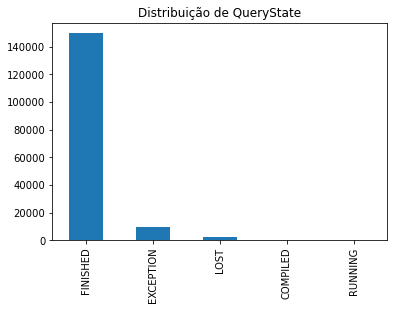

In [10]:
QueryState_qtd= consultas['queryState'].value_counts()
plot=QueryState_qtd.plot.bar(title="Distribuição de QueryState")

QueryState_qtd


In [11]:
qs_total=sum (QueryState_qtd)
qs_finished=QueryState_qtd['FINISHED']
qs_exception=QueryState_qtd['EXCEPTION']

print ((" {0:.2f}% são concluídos (finished) e {1:.2f}% são erros (exception)."+
       " Os demais estados correspondem {2:.2f}%").format(qs_finished/qs_total*100,
                                                   qs_exception/qs_total*100,
                                                   100-(qs_finished+qs_exception)/qs_total*100))

 92.53% são concluídos (finished) e 5.83% são erros (exception). Os demais estados correspondem 1.65%


In [12]:
consultas=consultas.loc[(consultas.queryState !="EXCEPTION") & (consultas.queryState !="LOST" ),['cpf_usuario','query_id','data_hora']].copy().reset_index(drop=True)

In [13]:
consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150107 entries, 0 to 150106
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   cpf_usuario  150107 non-null  object
 1   query_id     150107 non-null  object
 2   data_hora    150107 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB


## Correção do campo Data_hora

O campo INICIO apresenta UMA hora a mais que o real

In [14]:
# conversão do tipo do campo Data_hora de String para o Time
def str2time(val):
    try:
        return datetime.strptime(val,'%Y-%m-%d %H:%M:%S')
    except:
        return pd.NaT
consultas['inicio']= consultas.apply(lambda x: str2time(x.data_hora),axis=1)

# Reduão de 1 hora
consultas.loc[:,'inicio'] = consultas.inicio - timedelta(minutes=60)

# exclusão do campo data_hora
consultas.drop(columns=['data_hora'],inplace=True)

##  Junção das tabelas USUARIOS e CONSULTAS

In [15]:
consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150107 entries, 0 to 150106
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   cpf_usuario  150107 non-null  object        
 1   query_id     150107 non-null  object        
 2   inicio       150107 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 3.4+ MB


In [16]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80300 entries, 0 to 80299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cpf_usuario  80300 non-null  object
 1   orgao        80300 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [17]:
# Left join.
juncao=pd.merge(consultas,usuarios,how="left")

# Seleciona registros onde orgao é NAN, ou seja, não CPF não foi encontrado na tabela usuarios
juncao['desconhecido']= juncao.apply(lambda row: row.orgao!=row.orgao, axis=1)

# Mostra relação de CPF que não foram encontrados na tabela usuarios
juncao.loc[juncao.desconhecido,'cpf_usuario'].unique()

array(['02121308709', '08073230712', 's_cargaserpro',
       's_cg_microstrategy', 's_carga_sinac', 's_carga_pucomex',
       '94517789187', '33439114880', '09101404725', '77757327768',
       's_mcs_extracao', '02608485731', '08668729730', '92961070759',
       '87750813772', '05392214738', '05154921755', '02622929714',
       's_dlkrnet', '03767190796'], dtype=object)

In [18]:
# Atribui "prestadorSV" a orgão nos casos onde o CPF das consultas não foram encontrados na tabela usuários.
juncao.loc[juncao.desconhecido,'orgao']="prestadorSV"
juncao.drop(columns=['desconhecido'],inplace=True)

juncao.orgao.value_counts()

RF             133232
prestadorSV     16868
TC                  7
Name: orgao, dtype: int64

In [19]:
dados_pre=juncao.loc[(juncao.orgao!="prestadorSV"),['query_id','inicio']].reset_index(drop=True)

# Geração da base de dados

In [20]:
#DEFINIÇÃO DE PERÍODO
qtd_partes_1hora=1
delta=timedelta(minutes=60/qtd_partes_1hora)

periodo_dia=24*qtd_partes_1hora
periodo_semana=7*periodo_dia


In [21]:
inicioAnalise=datetime.strptime('2021-02-01 00:00:00','%Y-%m-%d %H:%M:%S')

# Pega o último tempo da serie
fimAnalise=str(dados_pre.sort_values('inicio').inicio.tail(1).values[0])
fimAnalise=fimAnalise[0:10]+" "+fimAnalise[11:19]
fimAnalise=datetime.strptime(fimAnalise,'%Y-%m-%d %H:%M:%S')
print (inicioAnalise,"<->",fimAnalise)

2021-02-01 00:00:00 <-> 2021-03-09 17:38:10


In [22]:
# Gera nova base
dados=pd.DataFrame(
    {'Tempo':[],'qtd':[]})

momento=inicioAnalise

while momento<fimAnalise:    
    qtd=dados_pre[(dados_pre.inicio >= (momento)) &
              (dados_pre.inicio <  (momento+delta))]['query_id'].count() 
    
    dados = dados.append({'Tempo':momento,'qtd':qtd}, ignore_index=True)
    
    print (momento,'qtd=',qtd)    
    
    momento+=delta
    
   

2021-02-01 00:00:00 qtd= 0
2021-02-01 01:00:00 qtd= 0
2021-02-01 02:00:00 qtd= 0
2021-02-01 03:00:00 qtd= 0
2021-02-01 04:00:00 qtd= 0
2021-02-01 05:00:00 qtd= 0
2021-02-01 06:00:00 qtd= 0
2021-02-01 07:00:00 qtd= 0
2021-02-01 08:00:00 qtd= 23
2021-02-01 09:00:00 qtd= 76
2021-02-01 10:00:00 qtd= 185
2021-02-01 11:00:00 qtd= 450
2021-02-01 12:00:00 qtd= 612
2021-02-01 13:00:00 qtd= 747
2021-02-01 14:00:00 qtd= 828
2021-02-01 15:00:00 qtd= 735
2021-02-01 16:00:00 qtd= 532
2021-02-01 17:00:00 qtd= 769
2021-02-01 18:00:00 qtd= 448
2021-02-01 19:00:00 qtd= 0
2021-02-01 20:00:00 qtd= 0
2021-02-01 21:00:00 qtd= 0
2021-02-01 22:00:00 qtd= 0
2021-02-01 23:00:00 qtd= 0
2021-02-02 00:00:00 qtd= 0
2021-02-02 01:00:00 qtd= 0
2021-02-02 02:00:00 qtd= 0
2021-02-02 03:00:00 qtd= 0
2021-02-02 04:00:00 qtd= 0
2021-02-02 05:00:00 qtd= 17
2021-02-02 06:00:00 qtd= 65
2021-02-02 07:00:00 qtd= 157
2021-02-02 08:00:00 qtd= 298
2021-02-02 09:00:00 qtd= 482
2021-02-02 10:00:00 qtd= 623
2021-02-02 11:00:00 qtd= 

2021-02-14 10:00:00 qtd= 10
2021-02-14 11:00:00 qtd= 9
2021-02-14 12:00:00 qtd= 10
2021-02-14 13:00:00 qtd= 26
2021-02-14 14:00:00 qtd= 22
2021-02-14 15:00:00 qtd= 68
2021-02-14 16:00:00 qtd= 42
2021-02-14 17:00:00 qtd= 23
2021-02-14 18:00:00 qtd= 26
2021-02-14 19:00:00 qtd= 0
2021-02-14 20:00:00 qtd= 0
2021-02-14 21:00:00 qtd= 0
2021-02-14 22:00:00 qtd= 0
2021-02-14 23:00:00 qtd= 0
2021-02-15 00:00:00 qtd= 0
2021-02-15 01:00:00 qtd= 0
2021-02-15 02:00:00 qtd= 0
2021-02-15 03:00:00 qtd= 0
2021-02-15 04:00:00 qtd= 0
2021-02-15 05:00:00 qtd= 1
2021-02-15 06:00:00 qtd= 10
2021-02-15 07:00:00 qtd= 34
2021-02-15 08:00:00 qtd= 85
2021-02-15 09:00:00 qtd= 57
2021-02-15 10:00:00 qtd= 9
2021-02-15 11:00:00 qtd= 95
2021-02-15 12:00:00 qtd= 129
2021-02-15 13:00:00 qtd= 163
2021-02-15 14:00:00 qtd= 191
2021-02-15 15:00:00 qtd= 100
2021-02-15 16:00:00 qtd= 93
2021-02-15 17:00:00 qtd= 146
2021-02-15 18:00:00 qtd= 131
2021-02-15 19:00:00 qtd= 0
2021-02-15 20:00:00 qtd= 0
2021-02-15 21:00:00 qtd= 0
20

2021-02-27 04:00:00 qtd= 0
2021-02-27 05:00:00 qtd= 0
2021-02-27 06:00:00 qtd= 36
2021-02-27 07:00:00 qtd= 48
2021-02-27 08:00:00 qtd= 42
2021-02-27 09:00:00 qtd= 52
2021-02-27 10:00:00 qtd= 94
2021-02-27 11:00:00 qtd= 80
2021-02-27 12:00:00 qtd= 45
2021-02-27 13:00:00 qtd= 67
2021-02-27 14:00:00 qtd= 92
2021-02-27 15:00:00 qtd= 64
2021-02-27 16:00:00 qtd= 54
2021-02-27 17:00:00 qtd= 64
2021-02-27 18:00:00 qtd= 90
2021-02-27 19:00:00 qtd= 100
2021-02-27 20:00:00 qtd= 0
2021-02-27 21:00:00 qtd= 0
2021-02-27 22:00:00 qtd= 0
2021-02-27 23:00:00 qtd= 0
2021-02-28 00:00:00 qtd= 0
2021-02-28 01:00:00 qtd= 0
2021-02-28 02:00:00 qtd= 0
2021-02-28 03:00:00 qtd= 0
2021-02-28 04:00:00 qtd= 0
2021-02-28 05:00:00 qtd= 0
2021-02-28 06:00:00 qtd= 1
2021-02-28 07:00:00 qtd= 20
2021-02-28 08:00:00 qtd= 29
2021-02-28 09:00:00 qtd= 33
2021-02-28 10:00:00 qtd= 125
2021-02-28 11:00:00 qtd= 42
2021-02-28 12:00:00 qtd= 40
2021-02-28 13:00:00 qtd= 49
2021-02-28 14:00:00 qtd= 69
2021-02-28 15:00:00 qtd= 86
202

# Análise e exploração dos dados



In [23]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Tempo   882 non-null    datetime64[ns]
 1   qtd     882 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


In [24]:
periodo=periodo_semana
qtd_periodo=len(dados)//periodo
ultimo_periodo=qtd_periodo*periodo

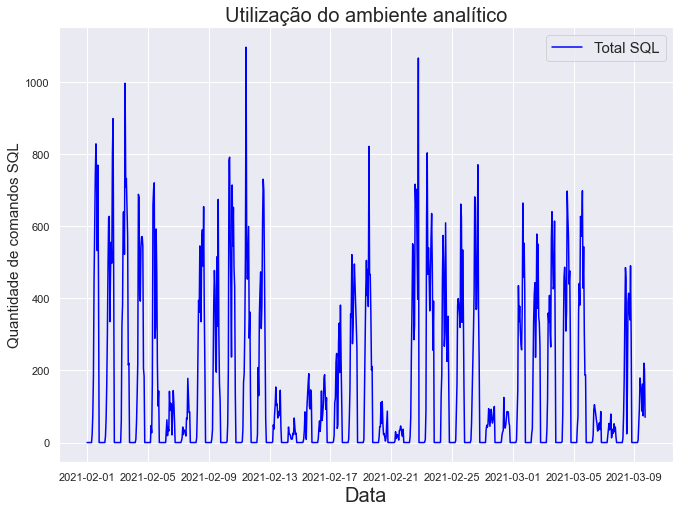

In [25]:
# Mostra a utilização do ambiente analítico

sns.set(rc={'figure.figsize':(11, 8)})
plt.plot(dados.loc[:,'Tempo'],dados.loc[:,'qtd'], color = 'blue', label = 'Total SQL')

plt.title('Utilização do ambiente analítico', fontsize=20)
plt.xlabel('Data', fontsize=20)
#plt.xticks(rotation=90)
plt.ylabel('Quantidade de comandos SQL', fontsize=15)
params = {'legend.fontsize': 15}
plt.rcParams.update(params)
plt.legend()
plt.show()

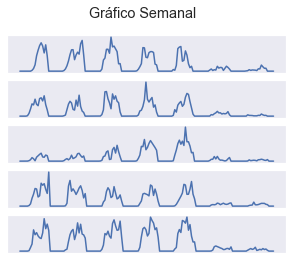

In [26]:
sns.set(rc={'figure.figsize':(5, 4)})
fig, axs = plt.subplots(qtd_periodo)
fig.suptitle('Gráfico Semanal')

for loop in range(qtd_periodo):
    axs[loop].plot(dados.qtd[periodo*loop:periodo*(loop+1)])
    axs[loop].grid(False)
    axs[loop].set_yticks([])
    axs[loop].set_xticks([])    

In [27]:
# Exclui o período do carnaval
antes=dados[:periodo*2]
depois=dados[periodo*3:qtd_periodo*periodo]
dados=antes.append(depois).reset_index(drop=True)
qtd_periodo-=1

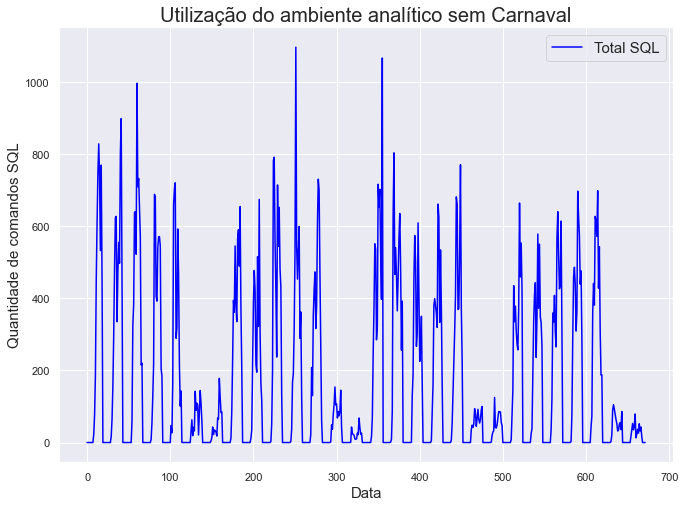

In [28]:
# Mostra a utilização do ambiente analítico
sns.set(rc={'figure.figsize':(11, 8)})
plt.plot(dados.loc[:,'qtd'].values, color = 'blue', label = 'Total SQL')
plt.title('Utilização do ambiente analítico sem Carnaval', fontsize=20)
plt.xlabel('Data', fontsize=15)
#plt.xticks(rotation=90)
plt.ylabel('Quantidade de comandos SQL', fontsize=15)
params = {'legend.fontsize': 15}
plt.rcParams.update(params)
plt.legend()
plt.show()

##  Segmentação da base de dados

In [29]:
#Segmenta os dados
total=dados.loc[:ultimo_periodo-1,'qtd'] # 3 semanas
treinamento = dados.loc[:((qtd_periodo-1)*periodo-1), 'qtd'] # 2 semanas
teste= dados.loc[(qtd_periodo-1)*periodo:(qtd_periodo)*periodo-1, 'qtd'] # 1 semana

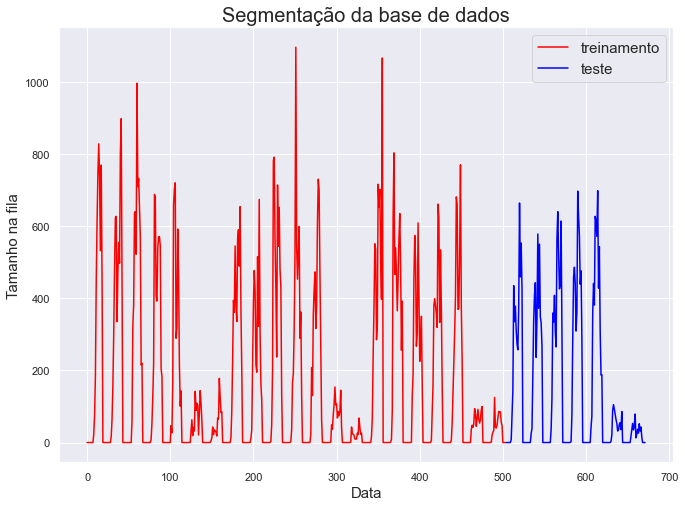

In [30]:
plt.plot(treinamento, color = 'red', label = 'treinamento')
plt.plot(teste, color = 'blue', label = 'teste')
plt.title('Segmentação da base de dados',fontsize=20)
plt.xlabel('Data',fontsize=15)
plt.ylabel('Tamanho na fila',fontsize=15)
params = {'legend.fontsize': 15}
plt.rcParams.update(params)
plt.legend()
plt.show()

# TECNICAS DE PREVISÃO DE SERIES TEMPORAIS

# 1) LSTM

In [31]:
def GeraJanelaTreina (entrada,janela):
    X_train = []
    y_train = []
    for i in range(janela, len(entrada)):
        X_train.append(entrada[i-janela:i, 0])
        y_train.append(entrada[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return (X_train,y_train)


In [32]:
def GeraModelo (X_train,y_train,un):
    model = Sequential()
    
    #cria nivel 1
    model.add(LSTM(units = un, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    #cria nivel 2
    model.add(LSTM(units = un, return_sequences = True))
    model.add(Dropout(0.2))

    #cria nivel 3
    model.add(LSTM(units = un, return_sequences = True))
    model.add(Dropout(0.2))
    
    #cria nivel 4
    model.add(LSTM(units = un))
    model.add(Dropout(0.2))
    
    #cria nivel de saida
    model.add(Dense(units = 1))

    # Compila a RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Treina a rede
    model.fit(X_train, y_train, epochs = 100, batch_size = 32)
    return (model)

In [33]:
def GeraJanelaTeste(total_set_scaled,tamanho_teste,janela):
    inputs = total_set_scaled[len(total_set_scaled) - tamanho_teste - janela:]
    X_test = []
    for i in range(janela, len(inputs)): # antes era 708
        X_test.append(inputs[i-janela:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return(X_test)

In [34]:
def aplica_modelo (janela,unidades,total,treinamento,teste):
    
    training_set = treinamento.values.reshape(-1,1)

    # Faz a transformação dos dados de treinamento para variarem de 0 a 1
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    #Prepara dados de treinamento
    X_train,y_train=GeraJanelaTreina(training_set_scaled,janela)

    # Gera modelo
    model=GeraModelo (X_train,y_train,unidades)

    # prepara dados para teste
    total_set=total.values.reshape(-1,1)
    total_set_scaled = sc.transform(total_set)
    X_test=GeraJanelaTeste(total_set_scaled,len(teste),janela)

    # aplica o modelo nos dados de teste
    predicted_scaled = model.predict(X_test)

    # Aplica a transformação inversa na previsão
    predicted = sc.inverse_transform(predicted_scaled)

    # evaluate forecasts
    rmse = float(math.sqrt(mean_squared_error(teste.values, predicted)))
    return (model,sc,rmse)

In [35]:
def grid_LTSM(lista_parametros,total,treinamento,teste):
   
    result=pd.DataFrame({'parametro':[],'RMSE':[]})
 
    for param in lista_parametros:
        
        try:
            print ("Gerando modelo LTSM {}".format(param))
            modelo,sc,rmse=aplica_modelo (param[0],param[1],total,treinamento,teste)            
        except:
            continue
        print ("RMSE = {}".format(rmse))
        result= result.append({'parametro':param,'RMSE':rmse}, ignore_index=True)           
        
    print(result)
    result = result.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
    
    return result

In [71]:
# Roda um grid com 256 possibilidades distinatas para procurar o SARIMA com melhor AIC
jan = [40,50,60,100,168]
unid = [20,25,30,40]
jan = [40]
unid = [20,25,30,40]

parameters = product(jan,unid)
parameters_list = list(parameters)

result_df11 = grid_LTSM(parameters_list,total,treinamento,teste)    
result_df11.head(5)


Gerando modelo LTSM (40, 40)
Epoch 1/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0503
Epoch 2/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0449
Epoch 3/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0393
Epoch 4/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0320
Epoch 5/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0278
Epoch 6/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0275
Epoch 7/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0255
Epoch 8/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0276
Epoch 9/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0268
Epoch 10/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0263
Epoch 11/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0240
Epoch 12/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0

15/15 [==============================] - 1s 41ms/step - loss: 0.0131
RMSE = 90.76512020642166
Gerando modelo LTSM (50, 30)
Epoch 1/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0505
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0444
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0431
Epoch 4/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0352
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0301
Epoch 6/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0283
Epoch 7/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0273
Epoch 8/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0265
Epoch 9/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0255
Epoch 10/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0260
Epoch 11/100
15/15 [==============================] - 1s 50ms/step

15/15 [==============================] - 1s 48ms/step - loss: 0.0152
Epoch 100/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0150
RMSE = 97.92947015824936
  parametro      RMSE
0  (40, 40)  90.76512
1  (50, 30)  97.92947


,parametro,RMSE
0,"(40, 40)",90.76512
1,"(50, 30)",97.92947


In [75]:
# Gera o modelo
janela=result_df11.loc[0][0][0]
unidades=result_df11.loc[0][0][1]
print (janela,unidades)
model,sc,rmse=aplica_modelo (janela,unidades,total,treinamento,teste) 

# prepara dados para teste
total_set=total.values.reshape(-1,1)
total_set_scaled = sc.transform(total_set)
X_test=GeraJanelaTeste(total_set_scaled,len(teste),janela)

# aplica o modelo nos dados de teste
predicted_scaled = model.predict(X_test)

# Aplica a transformação inversa na previsão
predicted = sc.inverse_transform(predicted_scaled)



40 40
Epoch 1/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0481
Epoch 2/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0447
Epoch 3/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0361
Epoch 4/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0284
Epoch 5/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0270
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0261
Epoch 7/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0253
Epoch 8/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0283
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0268
Epoch 10/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0237
Epoch 11/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0245
Epoch 12/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0234
Epoch 13/100
15/15 

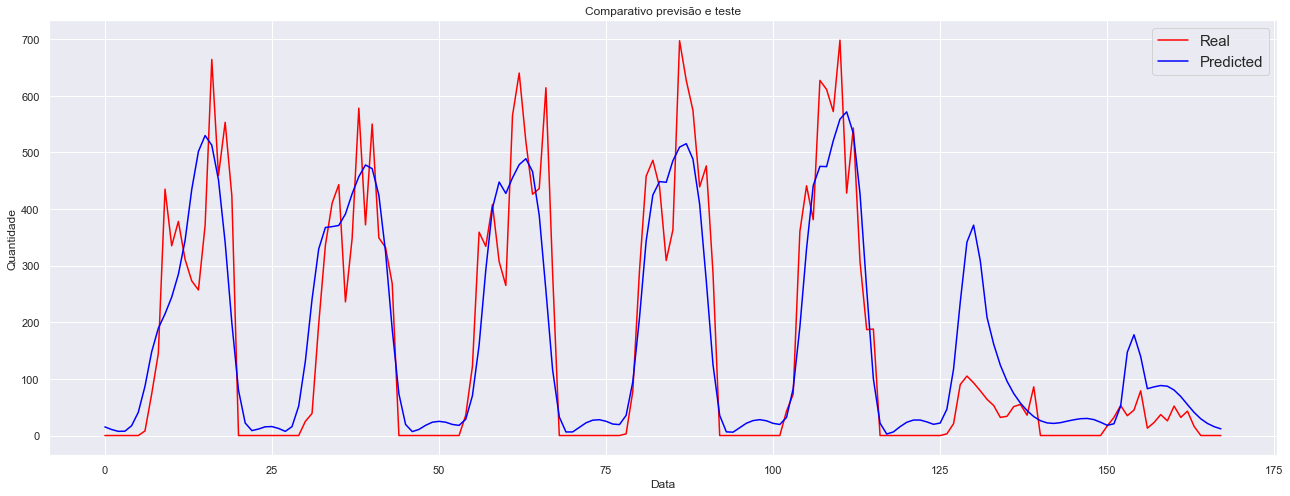

In [77]:
# Exibe os resultados
plt.plot(teste.values, color = 'red', label = 'Real')
plt.plot(predicted, color = 'blue', label = 'Predicted')
plt.title('Comparativo previsão e teste')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.show()

In [74]:
# calcula RMSE
rmse = math.sqrt(mean_squared_error(predicted, teste.values))
print('Test RMSE da LSTM: %.3f' % rmse)

Test RMSE da LSTM: 92.177


# 7) Manual - sarima

In [40]:
result = seasonal_decompose(treinamento.values,period=periodo_semana)

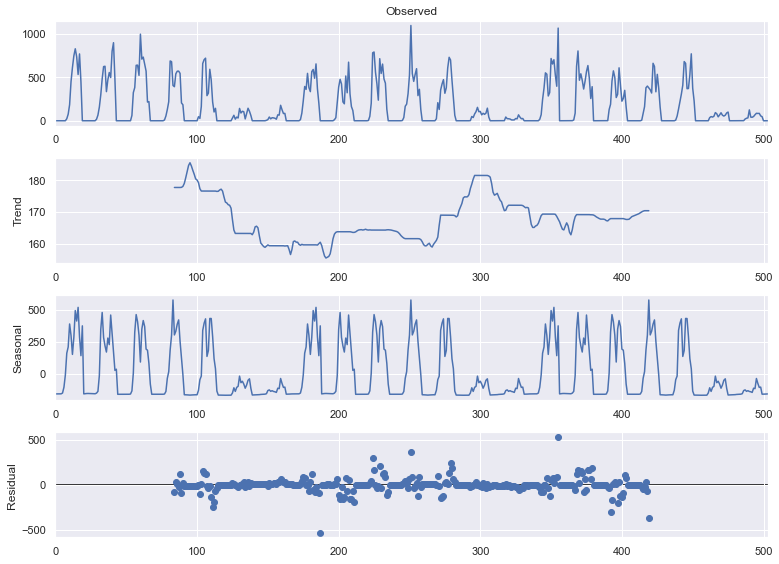

In [41]:
fig = result.plot()

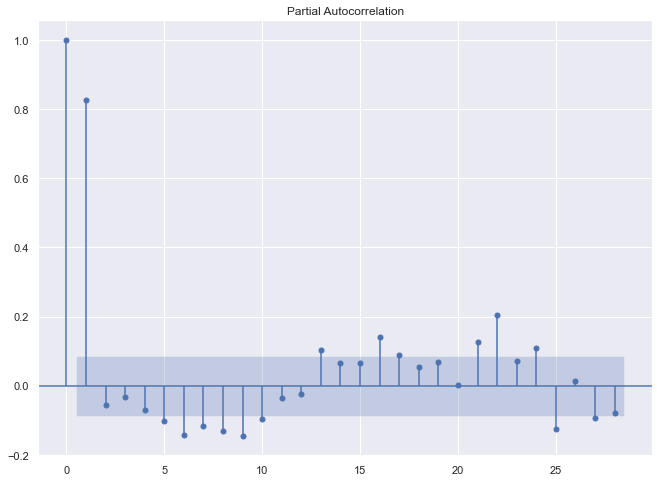

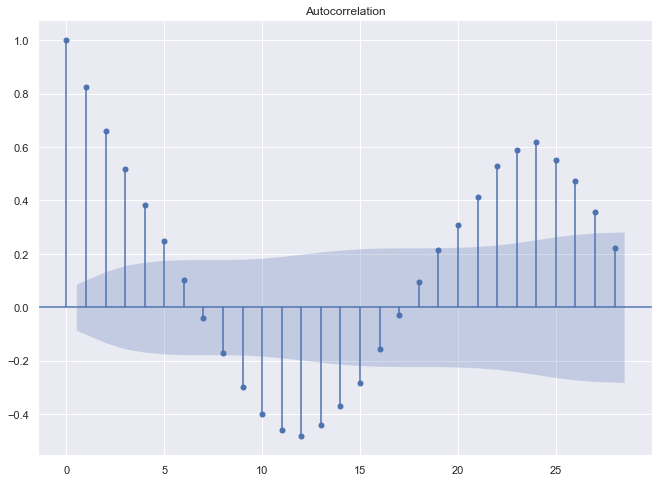

In [42]:
plot_pacf(treinamento);
plot_acf(treinamento);

In [43]:
# AR=1 (PACF tem um pico significante em 1 e outro em 7) ->P=1

In [44]:
# p-value < 0,05 -> Rejeitada a hipótse nula. Série é estacionária.
ad_fuller_result = adfuller(treinamento)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.5839778061071814
p-value: 0.006074829815845777


ADF Statistic:-12.534203448190095 ,p-value:2.3916245921394147e-23


<AxesSubplot:>

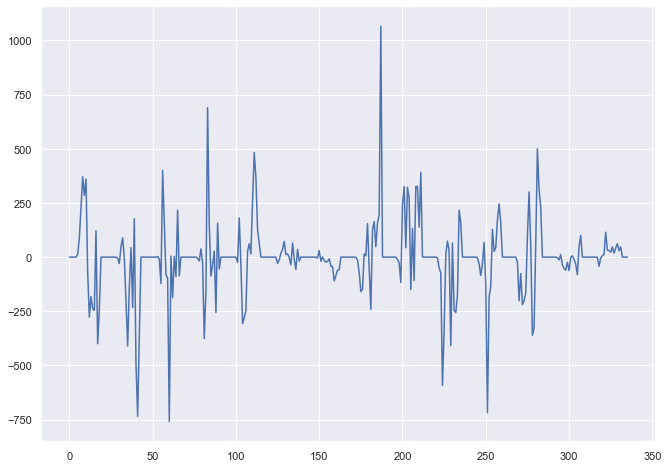

In [45]:
treinamento_aj = treinamento.diff(periodo)
treinamento_aj = treinamento_aj[periodo:].reset_index(drop=True)

ad_fuller_result = adfuller(treinamento_aj)
print('ADF Statistic:{} ,p-value:{}'.format(ad_fuller_result[0],ad_fuller_result[1]))
treinamento_aj.plot()

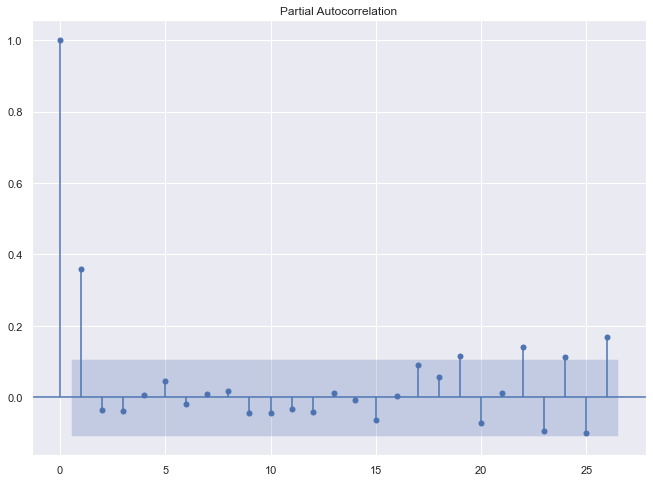

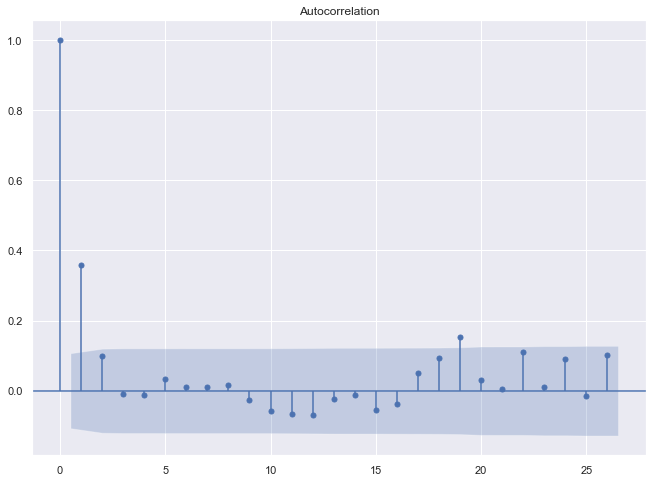

In [46]:
plot_pacf(treinamento_aj);
plot_acf(treinamento_aj);

In [47]:
def grid_SARIMA(lista_parametros, s, exog):
    aic=0
    result=pd.DataFrame({'(p,d,q)x(P,D,Q)':[],'AIC':[]})
 
    for param in lista_parametros:
        
        try:
            print ("Gerando modelo SARIMAX ({},{},{})({},{},{}){}".format(param[0], param[1], param[2],param[3], param[4], param[5], s))
            model = SARIMAX(exog, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)            
        except:
            continue
            
        aic = model.aic
        print ("AIC encontrado={}".format(aic))
        result= result.append({'(p,d,q)x(P,D,Q)':param,'AIC':qtd}, ignore_index=True)           
        
    result = result.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result

In [48]:
# Roda um grid com 256 possibilidades distinatas para procurar o SARIMA com melhor AIC
p = range(0, 4, 1)
d = range(1,2,1)
q = range(0, 4, 1)
P = range(0, 4, 1)
D = range (1,2,1)
Q = range(0, 4, 1)
s = periodo
parameters = product(p, d, q, P,D,Q)
parameters_list = list(parameters)

result_df11 = grid_SARIMA(parameters_list, periodo, treinamento.values)
    
result_df11.head(5)

,"(p,d,q)x(P,D,Q)",AIC
0,"(2, 1, 2, 1, 1, 0)",4317.099785
1,"(2, 0, 2, 1, 0, 0)",4318.012385
2,"(2, 0, 2, 1, 1, 0)",4321.798864
3,"(0, 1, 0, 0, 1, 1)",4430.038127
4,"(0, 1, 0, 1, 1, 0)",4430.645952


In [63]:
# Gera o modelo para o melhor AIC
melhor=result_df11.loc[0][0]
model = SARIMAX(treinamento.values, order=(melhor[0],melhor[1],melhor[2]), seasonal_order=(melhor[3],melhor[4],melhor[5], periodo)).fit()
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  504
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 168)   Log Likelihood               -2152.550
Date:                              Wed, 17 Mar 2021   AIC                           4317.100
Time:                                      13:58:45   BIC                           4339.985
Sample:                                           0   HQIC                          4326.223
                                              - 504                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6271      0.060    -10.455      0.000      -0.745      -0.510
ar.L2          0.37

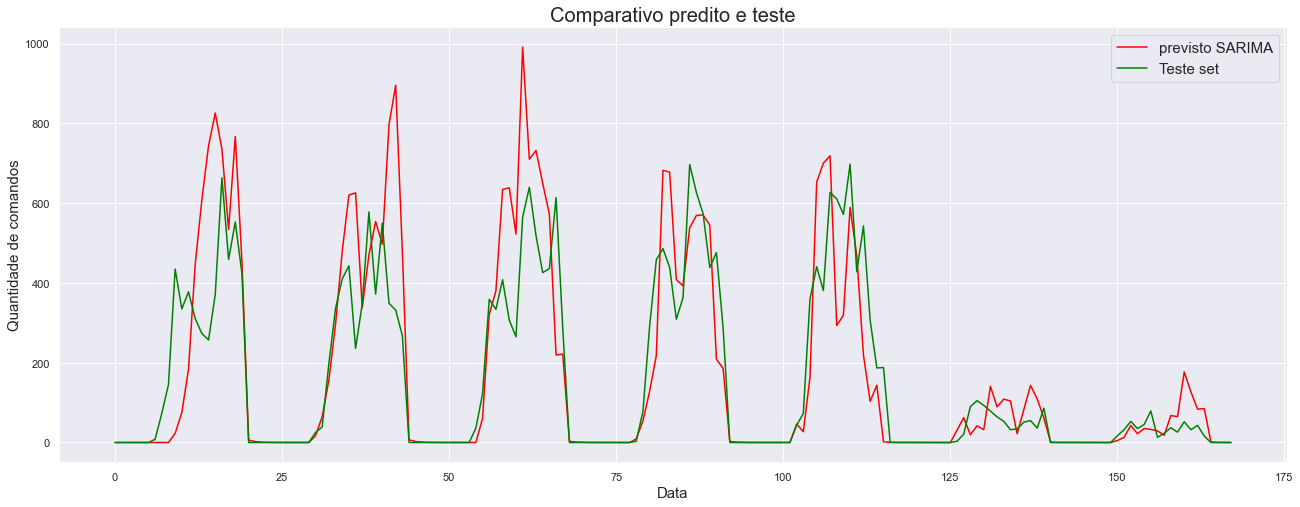

In [50]:
# Faz a previsão
forecast1 = model.predict()

# gera o gráfico comparando os resultados
sns.set(rc={'figure.figsize':(22, 8)})

plt.plot(forecast1[0:periodo], color = 'red', label = 'previsto SARIMA')
plt.plot(teste.values, color = 'green', label = 'Teste set')
plt.title('Comparativo predito e teste',fontsize=20)
plt.xlabel('Data',fontsize=15)
plt.ylabel('Quantidade de comandos',fontsize=15)
params = {'legend.fontsize': 15}
plt.rcParams.update(params)
plt.legend()
plt.show()


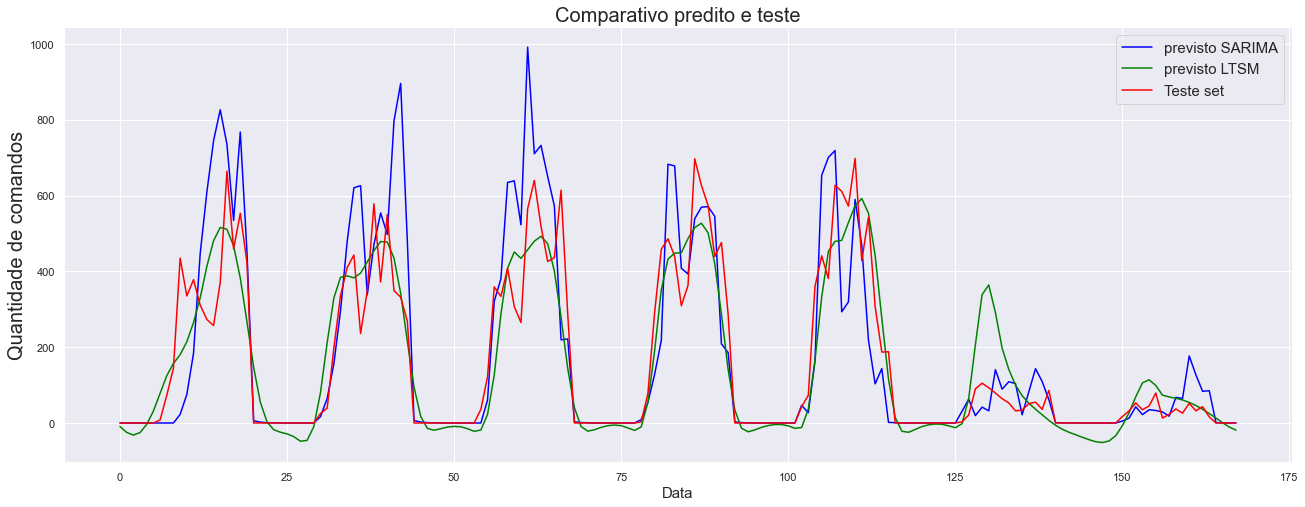

In [51]:
# Faz a previsão
forecast1 = model.predict()

# gera o gráfico comparando os resultados
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(22, 8)})

plt.plot(forecast1[0:periodo], color = 'blue', label = 'previsto SARIMA')
plt.plot(predicted, color = 'green', label = 'previsto LTSM')

plt.plot(teste.values, color = 'red', label = 'Teste set')
#plt.xticks(np.arange(0,587,50))
plt.title('Comparativo predito e teste',fontsize=20)
plt.xlabel('Data',fontsize=15)
plt.ylabel('Quantidade de comandos',fontsize=20)
params = {'legend.fontsize': 15}
plt.rcParams.update(params)
plt.legend()
plt.show()

In [52]:
# Gera RMSE para SARIMA
rmse = math.sqrt(mean_squared_error(forecast1[0:periodo], teste.values))
print('Test RMSE do modelo SARIMA: %.3f' % rmse)

Test RMSE do modelo SARIMA: 141.938
